In [1]:
import pandas as pd
from tqdm import tqdm
from top2vec import Top2Vec
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import zscore
from pathlib import Path
import yaml 
import datetime
import os

from helpers.linkage import *
from helpers import dataloader
from helpers.afa import adaptive_filter
from helpers.visuals import add_cabinet_periods
from helpers import style as style

style.load_style()
from matplotlib.dates import YearLocator, MonthLocator, DateFormatter

# Load Config
cf = yaml.safe_load(Path('config.yml').read_text())

/home/rb/.virtualenvs/phd_venv/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/rb/.virtualenvs/phd_venv/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/rb/.virtualenvs/phd_venv/lib/python3.10/site-packages/umap/distances.py:

In [2]:
dists = pd.read_csv('/home/rb/Documents/Data/models/lda/full-postwar-topics/dists-250',sep='\t',header=None).iloc[:,2:]
dists.columns = list(range(250))
data = pd.read_csv('/home/rb/Documents/Data/models/lda/full-postwar-topics/inference-data-full.tsv',sep='\t')   

In [3]:
# lda_path = '/home/rb/Documents/Data/models/lda/postwar-v2/'

# dat = pd.read_csv(lda_path + 'data.tsv',header=0,sep='\t',usecols=['speech_id','member-ref','role','date'])
# dat['date'] = pd.to_datetime(dat.date,infer_datetime_format=True)

# dists = pd.read_csv(lda_path + 'dist.tsv',header=None,sep='\t').iloc[:,2:]
# dists.columns = list(range(250))
# dists.index = dat.speech_id

In [11]:
# ## Load Metadata
# mtd = pd.read_csv('/home/rb/Documents/Data/metadata/session-metadata.tsv', sep='\t')
# dates = pd.read_csv('/home/rb/Documents/Data/metadata/dates.csv')
# dates = dict(zip(dates.id.str.split('.').str[4], pd.to_datetime(dates.date, infer_datetime_format=True)))
# mtd['date'] = mtd.session.map(dates.get).apply(lambda d: pd.Timestamp(year=d.year, month=1 if d.month < 7 else 6, day=1))

# mtd = mtd[(mtd.house == 'commons') & (mtd.date.dt.year > 1945)]
# mtdd = dict(zip(mtd.session, mtd.type))


# data['sesstype'] = data.speech_id.str.split('.').str[4].apply(lambda x: mtdd.get(x))
# data = data[data.sesstype == 'plenary']
# dists = dists.loc[data.index]

In [9]:
dists.index = pd.to_datetime(data.date,infer_datetime_format=True)

In [10]:
dists = {pd.Timestamp(year=y,month=1 if h == 0 else 6,day=1):_.to_numpy() for (y,h),_ in dists.groupby([dists.index.year,(dists.index.month-1)//6]) if len(_) > 25}
# dists = {q:_.to_numpy() for q,_ in dists.groupby(dists.index.to_period('Q')) if len(_) > 100}

In [11]:
def mutual_information(theta, topn=None):
    """
    theta (np.array): numpy array with rows as document-topic mixtures:
    
    returns:
    R_ij: np.array of linkage scores as measured with mutual information
    """
    if topn:
        theta = np.where(np.argsort(np.argsort(theta)) >= theta.shape[1]-topn, theta, 0.0000000001)

    p_ij = theta[:,:,None] * theta[:,None,:]
    p_ij = p_ij.sum(axis=0) / p_ij.sum()
    pt_i = theta.sum(axis=0)
    pt_i = pt_i / pt_i.sum()
    R_ij = np.log2(p_ij / (np.outer(pt_i.ravel(), pt_i.ravel())))
    ptj_i = p_ij / pt_i
    Ri = (R_ij * ptj_i).sum(axis=0)
    M = (Ri * pt_i).sum(axis=0)  
    return R_ij, Ri, M

In [12]:
stats = pd.DataFrame([{"year": y, "m": mutual_information(_, topn=None)[2]} for y, _ in tqdm(dists.items())])
stats = stats[stats.year.dt.year > 1945]

: 

: 

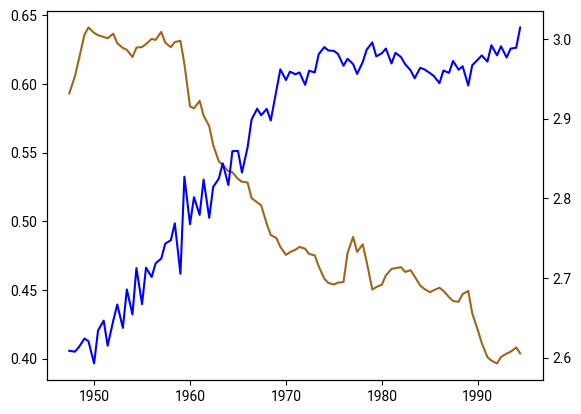

In [27]:
f, a = plt.subplots()

a.plot(stats.year,adaptive_filter(stats.m,span=48))

a1 = a.twinx()

a1.plot(e.date,e.e,color='blue',label='entropy')

In [28]:
dists

{Timestamp('1947-06-01 00:00:00'): array([[1.38731753e-03, 3.98016160e-02, 4.15300643e-04, ...,
         4.15101172e-04, 3.58773966e-04, 6.77360633e-04],
        [2.10675613e-03, 2.82175917e-03, 5.82509470e-02, ...,
         6.30365379e-04, 5.44827869e-04, 1.02862801e-03],
        [1.85188352e-05, 2.48038643e-05, 5.54370864e-06, ...,
         5.54104598e-06, 4.78915304e-06, 9.04185934e-06],
        ...,
        [6.48793438e-04, 8.68984696e-04, 1.94219655e-04, ...,
         1.94126371e-04, 1.67784368e-04, 3.16774729e-04],
        [8.06146048e-04, 1.07974054e-03, 2.41323969e-04, ...,
         2.41208061e-04, 2.08477302e-04, 3.93602465e-04],
        [7.72099125e-04, 1.03413858e-03, 2.31131847e-04, ...,
         2.31020834e-04, 1.99672432e-04, 3.76978984e-04]]),
 Timestamp('1948-01-01 00:00:00'): array([[1.29822962e-05, 1.79273267e-03, 3.88631720e-06, ...,
         3.88445059e-06, 3.35734957e-06, 6.33863281e-06],
        [4.38639007e-04, 5.87506842e-04, 1.31308845e-04, ...,
         1.3124

In [17]:
from scipy.stats import entropy

In [24]:
e = pd.DataFrame([{"date":k,"e":np.apply_along_axis(entropy, 1, a).mean()} for k,a in dists.items()])

In [25]:
e

,date,e
0,1947-06-01,2.608717
1,1948-01-01,2.607599
2,1948-06-01,2.613338
3,1949-01-01,2.624118
4,1949-06-01,2.620696
...,...,...
90,1992-06-01,2.990792
91,1993-01-01,2.976635
92,1993-06-01,2.987819
93,1994-01-01,2.988986


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


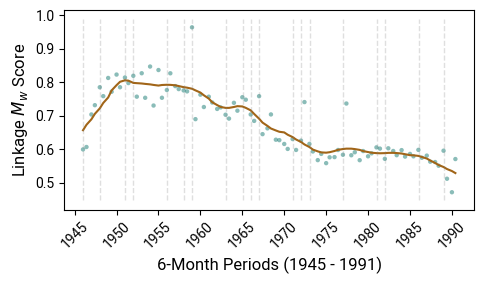

In [14]:
fig,ax = plt.subplots(1,1,figsize=(5,3))

X = stats.year
Y = stats.m

ax.scatter(X,Y,c=sns.color_palette('BrBG')[-1],alpha=.5,marker='o',ec=None,s=10)
ax.plot(X,adaptive_filter(Y,span=25))

add_cabinet_periods(ax,text=False,color='grey',max_time=1994,alpha=.25)

ax.tick_params(axis='x',labelrotation=45)
ax.set_ylabel(r'Linkage $M_w$ Score')
ax.set_xlabel(r'6-Month Periods (1945 - 1991)')

fig.tight_layout()
plt.savefig('/home/rb/Desktop/linkage-diachronic-speech-level-plenary.png',dpi=250,bbox_inches='tight')
plt.show()

In [10]:
keys = pd.read_csv('/home/rb/Documents/Data/models/lda/full-postwar/keys-speech-bound-250',sep='\t')
labels = dict(zip(keys.index,keys.label))
labels_reverse =dict(zip(labels.values(),labels.keys()))

In [20]:
import random

In [35]:
rks = dists.copy().rank(1, ascending=False)

r = []
for c,i in enumerate(rks.columns):
    t = str(i)
    ts = rks[[t]]
    df = pd.DataFrame([
    {
        'd': i,
        'rank2': len(d[(d[t] != 1) & (d[t] < 5)]) / len(d),
        'rank1': len(d[d[t] == 1]) / len(d)
    }
    for i, d in ts.groupby(ts.index.year)
    ])
    df = df.set_index('d')
    df = df.apply(zscore)
    r.append({"topic":labels[int(i)],"c":np.corrcoef(df.rank1,df.rank2)[0,1]})

In [37]:
pd.DataFrame(r).sort_values('c').head(15)

,topic,c
171,rhet,-0.128930
109,administrative performance,-0.031463
44,proc,0.037542
241,institutional competences,0.065617
61,exports,0.089473
143,proc,0.165632
147,rhet/news sources,0.201816
156,proc/house opinions,0.247351
130,international politics,0.277843
18,employment,0.335967
